## Preprocessing

In [4]:
import OpenLA as la
import sys
import os
import re
import numpy as np
import datetime as dt
import pandas as pd

In [5]:
actions_txt_path = r".\data\actions_txt"
Edudata = r'.\data\EduData_20221028'
courses = ["A-2020","D-2020","A-2021","D-2021","A-2022","D-2022"]

In [6]:
Operation_dict = {
        'NEXT':'N',
        'PREV':'P',
        'ADD MARKER':'A',

        'OPEN':'O',             # 'E'
        'CLOSE':'C',            # 'E'
        'PAGE_JUMP':'J',        # 'E'
        'GETIT':'G',            # 'E'

        'DELETE MARKER':'E',
        'BOOKMARK_JUMP':'E',
        'ADD BOOKMARK':'E',
        'NOTGETIT':'E',
        'ADD MEMO':'E',
        'MEMO_TEXT_CHANGE_HISTORY':'E',

        'DELETE BOOKMARK':'E',
        'CHANGE MEMO':'E',
        'SEARCH_JUMP':'E',
        'REGIST CONTENTS':'E',
        'DELETE_MEMO':'E',
        'SEARCH':'E',
        'OPEN_RECOMMENDATION':'E',
        'CLICK_RECOMMENDATION':'E',
        'TIMER_PAUSE':'E',
        'TIMER_STOP':'E',
        'ADD_HW_MEMO':'E',

        'CLOSE_RECOMMENDATION':'E',
        'CLEAR_HW_MEMO':'E',
        'LINK_CLICK':'E',
        'UNDO_HW_MEMO':'E',
        'ADD_RECOMMENDATION' : 'E',
        'REDO_HW_MEMO' : 'E',
        'DELETE_RECOMMENDATION' : 'E',
        'MEMO_JUMP' : 'E'
        }


def get_learninglog_sentences(eventstream, userid):
    user_eventstream_df = get_user_eventstream(eventstream,userid)
    return get_oneuser_sentences(user_eventstream_df)

def get_user_eventstream(eventstream, userid):
    user_stream = la.select_user(eventstream, userid)
    user_stream_df = user_stream.df.sort_values(["contentsid", "eventtime"])
    user_stream_df = user_stream_df[["contentsid", "operationname","eventtime"]]
    df = user_stream_df.replace(Operation_dict)
    df.index = np.arange(0, len(df))  
    return   df

def get_oneuser_sentences(user_eventstream_df):
  # sentences : output
  # word     : component of sentence
  # current  : event time of current operation
  # previous : event time of previous operation
  # cc       : lecuture materials which the current operation took place
  # pc       : lecuture materials which the previous operation took place
  # start    : Time stamp at the beginning of the word
  # end      : time limit of currentword 
    sentences = ""
    word = ""
    current = dt.datetime.now()
    end = dt.datetime.now()
    cc  = ""
    word_max_len = 15
    for index, data in user_eventstream_df.iterrows():
      if index == 0:                                                             
          current = dt.datetime.strptime((data["eventtime"]), '%Y-%m-%d %H:%M:%S')
          cc = data["contentsid"]
      else:
          pc = cc
          cc = data["contentsid"]
          if pc != cc:
            sentences += (word + '\n')
            word = data['operationname']
            current = dt.datetime.strptime(data["eventtime"], '%Y-%m-%d %H:%M:%S')
            start = current
            end = start + dt.timedelta(minutes=1)
            continue
          else:
            previous = current
            current = dt.datetime.strptime(data["eventtime"], '%Y-%m-%d %H:%M:%S')
            interval_sec = current - previous
            interval_sec = interval_sec.seconds
            interval_word = interval_check(interval_sec)
            word += interval_word
            if interval_word == 'l' :
              sentences += (word + '\n')
              word = data['operationname']
              start = current
              end = start + dt.timedelta(minutes=1)
              if index != len(user_eventstream_df)-1:
                continue
            elif  len(word) >= word_max_len - 1:
              sentences += (word + '_ ')
              word = data['operationname']
              start = current
              end = start + dt.timedelta(minutes=1)
              continue
      if index == len(user_eventstream_df)-1:
        if index == 0:
          sentences = data['operationname'] 
        elif current <= end:
          word += data['operationname'] 
          sentences += word
        else:
          sentences += (word + ' ')
          sentences += data['operationname']
      elif index == 0:
          start = current
          end = start + dt.timedelta(minutes=1)
          word = data['operationname']
      elif current <= end:
          word += data["operationname"]
      else :
        sentences += (word + ' ')
        word = data["operationname"]
        start = current
        end = start + dt.timedelta(minutes=1)   
    if sentences != "":
        return (sentences + '\n') 
    
def interval_check(interval_sec:int):
    if interval_sec <= 1:
      interval_word = ''
    elif interval_sec > 1 and interval_sec <= 10:
      interval_word = 's'
    elif interval_sec > 10 and interval_sec <= 300:
      interval_word = 'm'    
    else:
      interval_word = 'l'
    return interval_word

  # ファイル書き出し
def write_sentences(file_path, actions,usersid,train_flg=0):
    i = 0
    f = open(file_path, 'w')
    for action in actions:
      if action != None:
        f.write(action)
        if train_flg ==0:
            f.write('****{}****\n'.format(usersid[i]))
        i+=1
    f.close()

### EventStream to Sentences

In [7]:
def get_Actions_train(course_id):
    print(course_id)
    actions_file = actions_txt_path + r"\actions_{}.txt".format(course_id)
    # 指定のコースのEventStream を取得
    course_info = la.CourseInformation(files_dir=Edudata, course_id=course_id)
    eventstream = course_info.load_eventstream()
    #print(eventstream)
    # get students' user id in selected course
    usersid = course_info.user_id()
    #print(usersid)
    # get actions from student activity in selected course
    actions=[get_learninglog_sentences(eventstream,userid) for userid in usersid]
    # save file
    write_sentences(actions_file, actions,usersid,train_flg=1)

In [8]:
for course in courses:
    get_Actions_train(course)

A-2020


c:\Users\miyazakiyuma\.pyenv\pyenv-win\versions\3.8.7\lib\site-packages\OpenLA\course_information.py:30: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  self._df = pd.read_csv(file_path)


D-2020
A-2021
D-2021
A-2022


c:\Users\miyazakiyuma\.pyenv\pyenv-win\versions\3.8.7\lib\site-packages\OpenLA\course_information.py:30: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  self._df = pd.read_csv(file_path)


D-2022


make ALL-2020 actions textfile

In [9]:
def find_files(dir, pattern):
    matched_files = []
    regex = re.compile(pattern)
    for root, dirs, files in os.walk(dir):
        for file in files:
            if regex.match(file):
                matched_files.append(os.path.join(root, file))
    return matched_files

def concat_files(files,year):
    with open(actions_txt_path + r"\actions_ALL-{}.txt".format(year), "w") as new_file:
        for name in files:
            with open(name) as f:
                for line in f:
                    new_file.write(line)           
                new_file.write("\n")

In [10]:
year = "2020"
pattern = r'actions_[A-Z]-{}.txt'.format(year)
matched_fiels = find_files(actions_txt_path, pattern)
concat_files(matched_fiels,year)

### actions to making vector (split by each user) 

In [11]:
def get_Actions_Students(course_id):
    actions_file = actions_txt_path + r"\actions_{}_perStudents.txt".format(course_id)
    # 指定のコースのEventStream を取得
    course_info = la.CourseInformation(files_dir=Edudata, course_id=course_id)
    eventstream = course_info.load_eventstream()
    # get students' user id in selected course
    usersid = eventstream.user_id()
    # get actions from student activity in selected course
    actions=[get_learninglog_sentences(eventstream, userid) for userid in usersid]
    # save file
    write_sentences(actions_file, actions,usersid)

In [12]:
for course in courses:
    get_Actions_Students(course)

c:\Users\miyazakiyuma\.pyenv\pyenv-win\versions\3.8.7\lib\site-packages\OpenLA\course_information.py:30: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  self._df = pd.read_csv(file_path)
c:\Users\miyazakiyuma\.pyenv\pyenv-win\versions\3.8.7\lib\site-packages\OpenLA\course_information.py:30: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  self._df = pd.read_csv(file_path)


### Figure 3

In [22]:
import matplotlib.pyplot as plt

In [23]:
columns = ["userid", "num_units", "num_actions"]

In [24]:
for course_id in ["A-2022", "D-2022"]:
    data_list = []
    actions_file = actions_txt_path + r"\actions_{}_perStudents.txt".format(course_id)
    with open(actions_file,"r") as f:
        num_word = 0
        num_sentences = 0
        for line in f:
            if line.startswith("****"):
                userid = line.strip()
                userid = userid.strip("****")
                data_list.append([userid,num_word,num_sentences])
                num_word = 0
                num_sentences = 0
            else:
                num_word += len(line.strip().split(' '))
                num_sentences +=1
    df = pd.DataFrame(data_list,columns=columns)
    df = df.set_index("userid")
    df.to_csv(actions_txt_path + r'\{}_words_sentences_count.csv'.format(course_id))

In [25]:
df_a = pd.read_csv(actions_txt_path + r'\{}_words_sentences_count.csv'.format("A-2022"))
df_d = pd.read_csv(actions_txt_path + r'\{}_words_sentences_count.csv'.format("D-2022"))

In [26]:
data1 = df_a["num_actions"]
data2 = df_d["num_actions"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


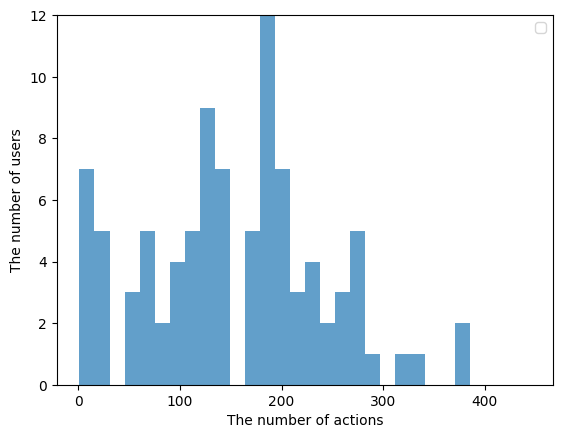

In [27]:
bins = np.histogram_bin_edges(np.concatenate((data1, data2)), bins=30)

# ヒストグラムを描画
n1, _ = np.histogram(data1, bins=bins)
n2, _ = np.histogram(data2, bins=bins)

# ヒストグラムを描画
plt.hist(bins[:-1], bins, weights=n2, alpha=0.7)


# 凡例を追加
plt.legend()

# 縦軸の最大値を共通の最大値に設定
max_height = max(max(n1), max(n2))
plt.ylim(0, max_height)
plt.xlabel('The number of actions')
plt.ylabel('The number of users')
# グラフを表示
plt.show()